# TorchVision Instance Segmentation



In [23]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-9318irbz
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-9318irbz


### Writing a custom dataset for Bottle classifier
We create a directory by the name of "dataset1" and assign 2 folders "images" to store the inamges and "annotations" to store the mask/exr files

### Importing and image and opeining it

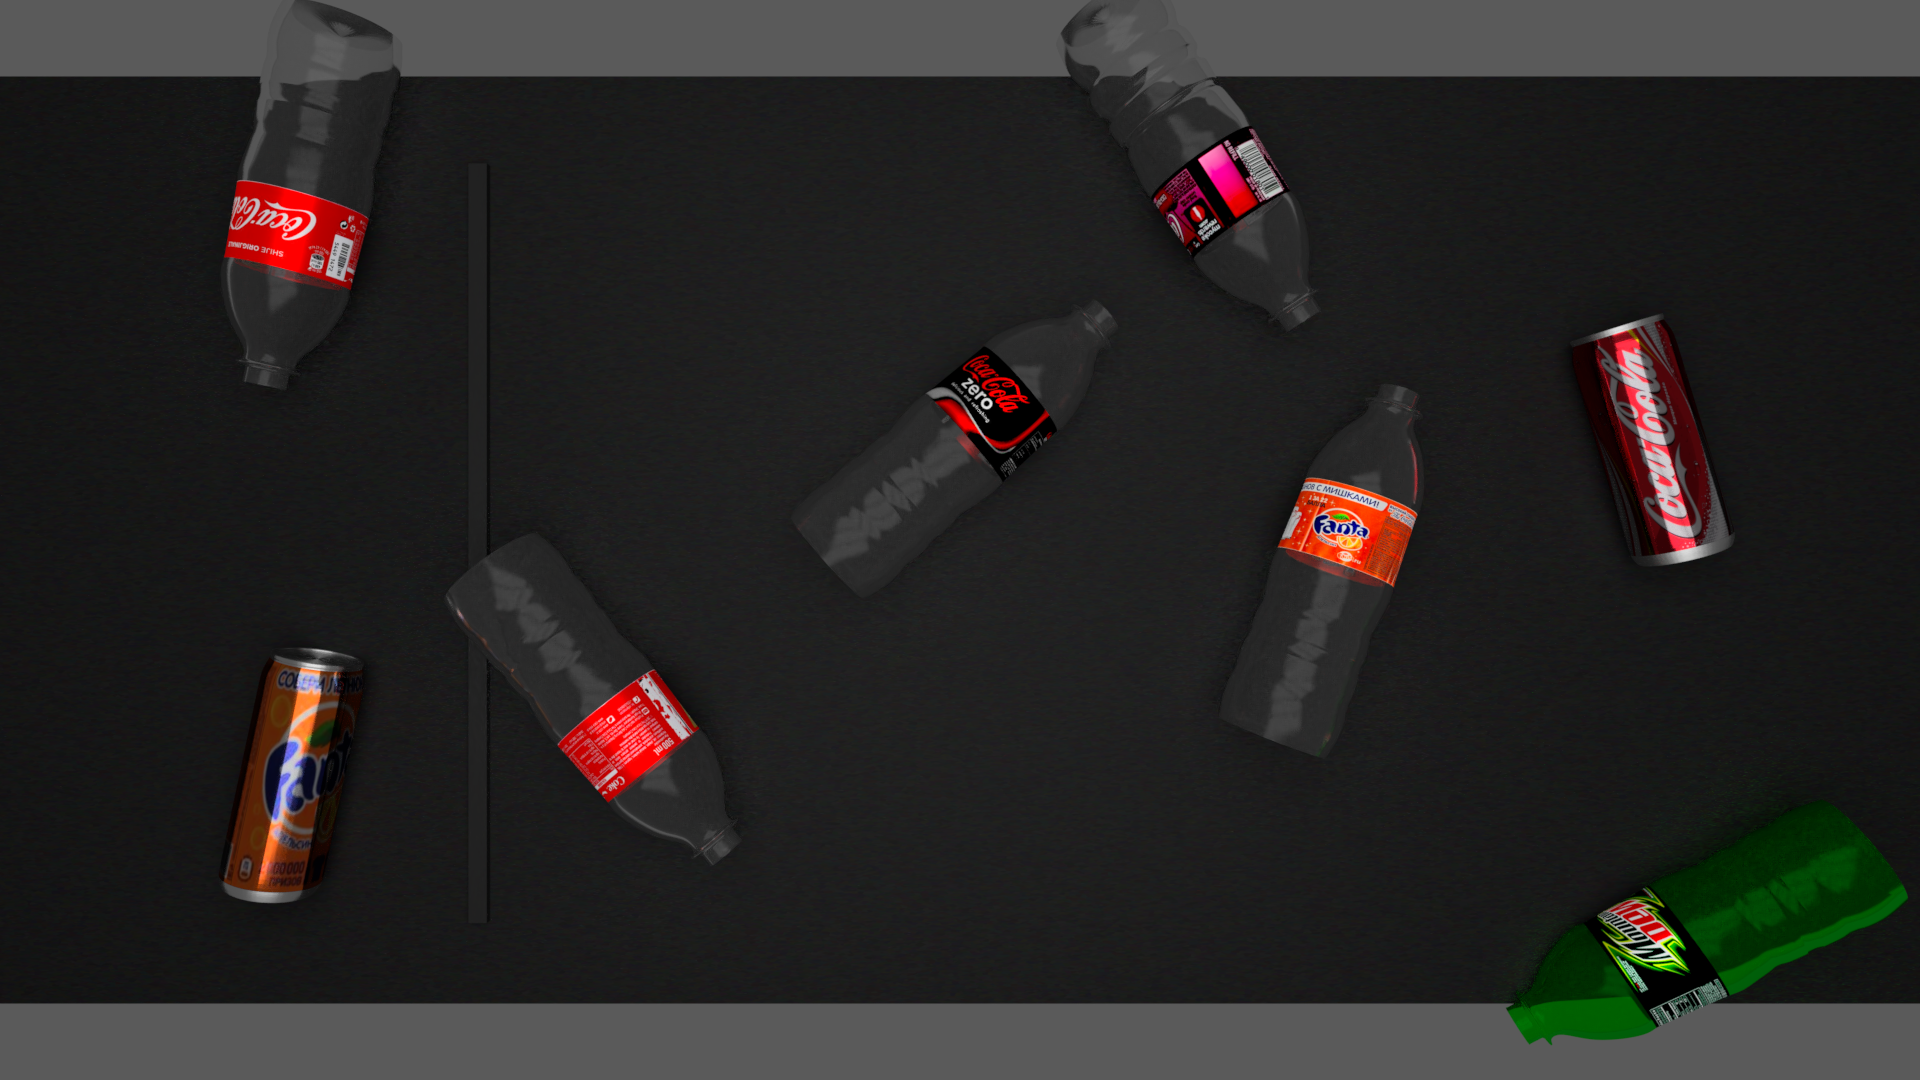

In [24]:
from PIL import Image
Image.open('/content/dataset1/images/Image0170.png')

### Reading EXR file

We see that the image is completele dark since the pixel value is from 0 to 7 for all the masks.

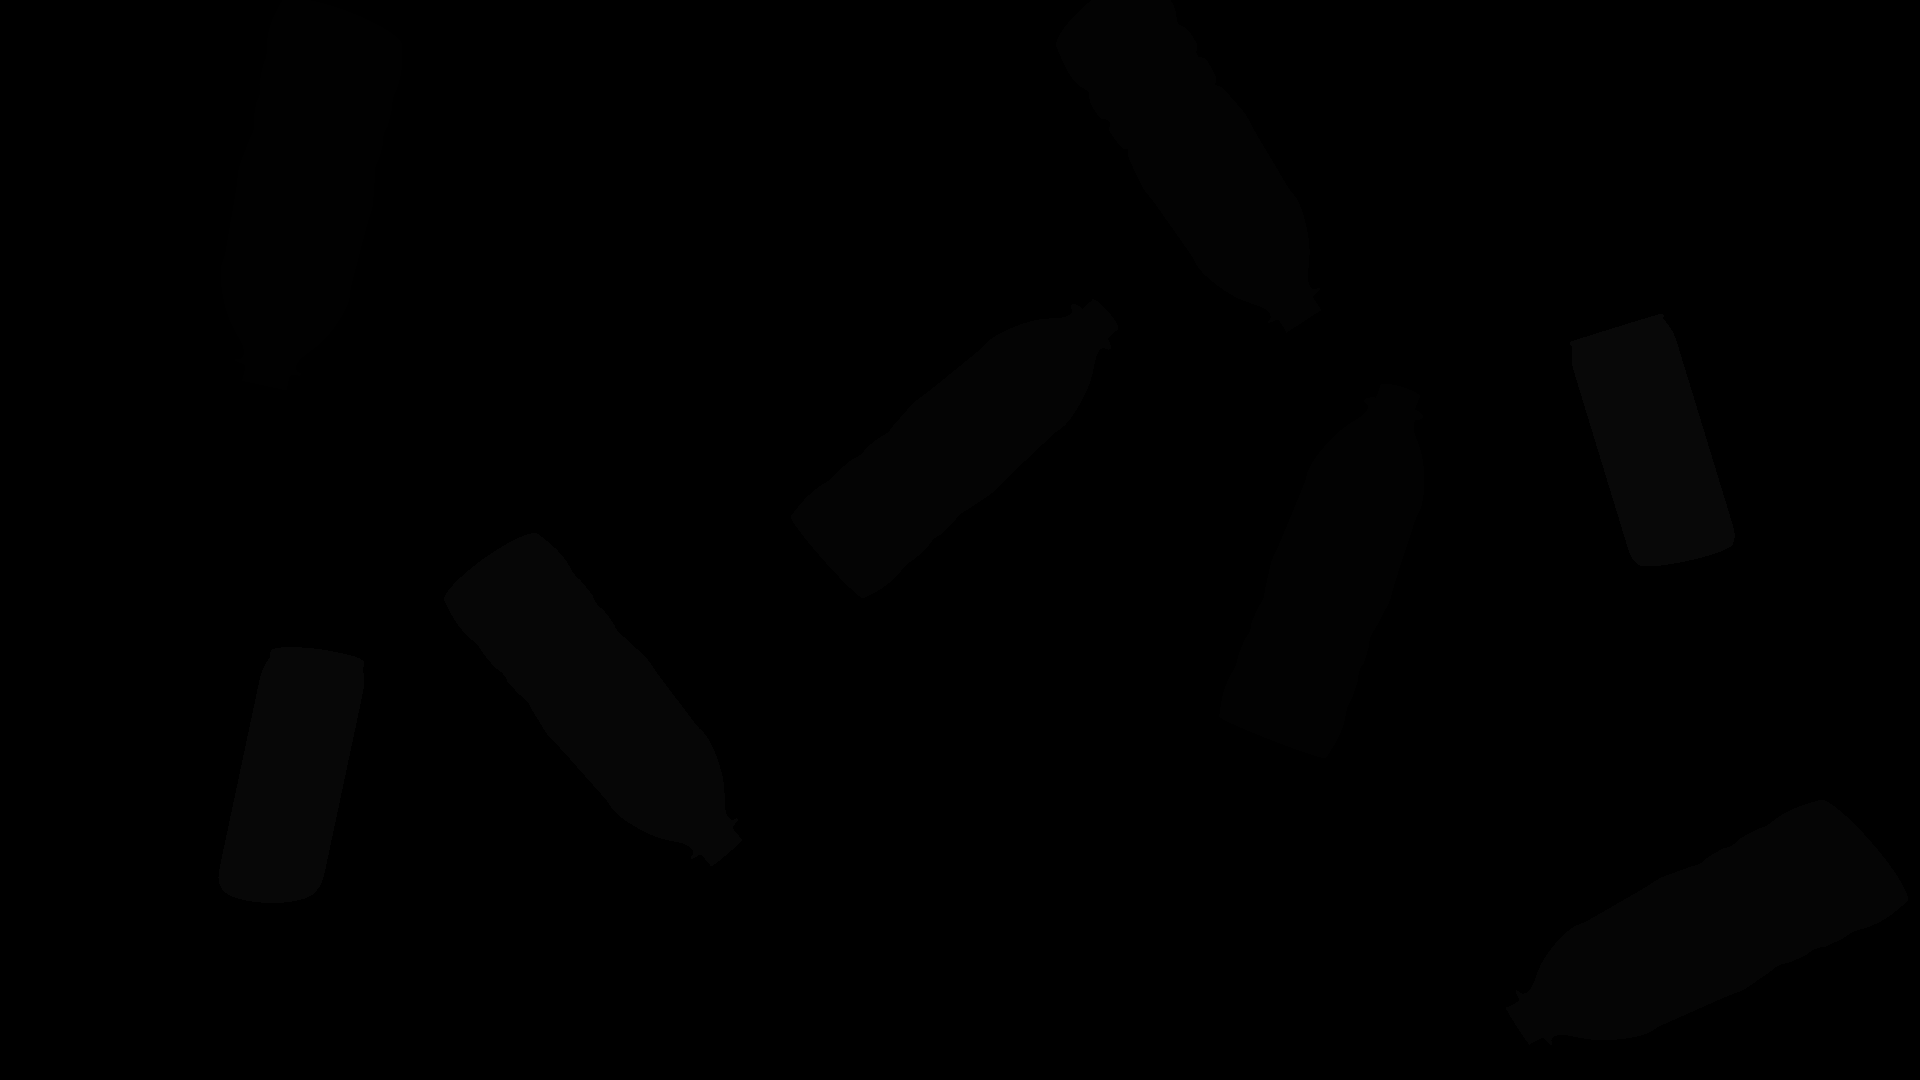

In [25]:
#uncomment to download torch_snippet and fastcore

#!pip install torch_snippets==0.320
#!pip install fastcore

from torch_snippets import *
mask = read(f'/content/dataset1/annotations/Image0170.exr')
data = Image.fromarray(mask) #convert to image
data

Each image has a corresponding segmentation mask, where each color correspond to a different instance. 

Below is the `torch.utils.data.Dataset` class for this dataset.

In [46]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
from torch_snippets import *

class Bottle_data(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "annotations"))))
        #print(len(self.imgs))
        #print(len(self.masks))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        #print(img_path)
        mask_path = os.path.join(self.root, "annotations", self.masks[idx])
        #print(mask_path)
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = read(mask_path)

        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        i = 0
        
        #convert the each mask tensor to represent one image of the bottle in whole image
        for i in range(1,len(masks)):

            masks[i] = np.where(masks[i] == 1, i, 0)

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there are 9 classes including background
        labels = torch.tensor(obj_ids, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        #all instances are not crowd (R-CNN optional requirement)
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

We get the area, boxes coordinates, image_id, labels and masks as shown below


In [47]:
#!rm -rf `find -type d -name .ipynb_checkpoints`
dataset = Bottle_data('/content/dataset1')
dataset[0]

(<PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F14F647A650>,
 {'area': tensor([ 54209., 104960.,  82628.,  83846., 100473.,  68991.,  27615.,  53000.]),
  'boxes': tensor([[ 208.,  753.,  567.,  904.],
          [1548.,   89., 1868.,  417.],
          [ 174.,  104.,  538.,  331.],
          [ 994.,  134., 1220.,  505.],
          [1287.,  748., 1600., 1069.],
          [ 560.,  482.,  743.,  859.],
          [1230.,  360., 1493.,  465.],
          [1541.,  630., 1806.,  830.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0]),
  'labels': tensor([1, 2, 3, 4, 5, 6, 7, 8]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           

## Defining your model

Using [Mask R-CNN](https://arxiv.org/abs/1703.06870), which is based on top of [Faster R-CNN](https://arxiv.org/abs/1506.01497). Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image.

Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

### 1 - Finetuning from a pretrained model since data is small

Since we want to also compute the instance segmentation masks, so we will be using Mask R-CNN:

In [48]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


## Training and evaluation functions
Using helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.


In [43]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.8.2

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

fatal: destination path 'vision' already exists and is not an empty directory.
HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)




Writing helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [49]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

#### Testing forward() method 

Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.


In [51]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = Bottle_data('/content/dataset1', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions
print(predictions)


[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}, {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}]


### Initiating the data preparation functions

In [52]:
# use our dataset and defined transformations
dataset = Bottle_data('/content/dataset1', get_transform(train=True))
dataset_test = Bottle_data('/content/dataset1', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-30])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-30:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

Instantiating the model and the optimizer

In [53]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 9 classes including the background
num_classes = 9

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 10 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Training the model for 4 epochs, evaluating at the end of every epoch.

In [54]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/84]  eta: 0:03:25  lr: 0.000065  loss: 6.2629 (6.2629)  loss_classifier: 2.1776 (2.1776)  loss_box_reg: 0.9694 (0.9694)  loss_mask: 3.0988 (3.0988)  loss_objectness: 0.0092 (0.0092)  loss_rpn_box_reg: 0.0078 (0.0078)  time: 2.4447  data: 1.5753  max mem: 3769
Epoch: [0]  [ 1/84]  eta: 0:02:17  lr: 0.000125  loss: 6.2048 (6.2339)  loss_classifier: 2.1579 (2.1678)  loss_box_reg: 0.9694 (0.9734)  loss_mask: 3.0531 (3.0760)  loss_objectness: 0.0090 (0.0091)  loss_rpn_box_reg: 0.0075 (0.0077)  time: 1.6618  data: 0.8180  max mem: 3769
Epoch: [0]  [ 2/84]  eta: 0:01:53  lr: 0.000186  loss: 6.2048 (6.2233)  loss_classifier: 2.1579 (2.1521)  loss_box_reg: 0.9773 (0.9886)  loss_mask: 3.0531 (3.0656)  loss_objectness: 0.0090 (0.0089)  loss_rpn_box_reg: 0.0078 (0.0080)  time: 1.3834  data: 0.5601  max mem: 3769
Epoch: [0]  [ 3/84]  eta: 0:01:40  lr: 0.000246  loss: 6.2022 (6.1467)  loss_classifier: 2.1209 (2.1235)  loss_box_reg: 0.9773 (0.9973)  loss_mask: 3.0450 (3.0100)  loss_ob

Storing the predictions from the test data

In [69]:
#20 images from the test set
img = [None]*20
prediction = [None]*20
for i in range(20):
    img[i], _ = dataset_test[i]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
      prediction[i] = model([img[i].to(device)])

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

In [70]:
prediction[0]

[{'boxes': tensor([[ 845.2293,  343.6894, 1094.0100,  503.5420],
          [  80.3972,  626.3301,  355.6682,  977.2568],
          [ 968.5529,  604.5632, 1086.6934,  850.9050],
          [ 914.8134,   73.8836, 1291.2734,  269.3404],
          [1195.4513,  505.8633, 1534.2711,  798.7935],
          [ 362.7859,  732.8396,  761.4949,  873.9833],
          [ 273.1673,  386.5975,  479.9649,  768.8798],
          [ 320.7018,   44.6562,  666.9595,  344.5913],
          [ 324.9419,   51.0746,  662.4803,  347.4806],
          [ 265.5511,  375.1155,  487.9943,  763.4216],
          [ 366.1895,  727.7825,  765.0601,  876.3860],
          [1202.6527,  510.5937, 1534.5482,  801.3487]], device='cuda:0'),
  'labels': tensor([8, 5, 7, 3, 4, 2, 6, 6, 1, 1, 4, 3], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.

### Below are the predicted masks along with the classes mentioned.

coke 1 - class:1

fanta - class:2

cherry coke - class:3

coke zero - class:4

mountain dew - class:5

coke 2 - class:6

fanta can - class:7

coke can - class:8







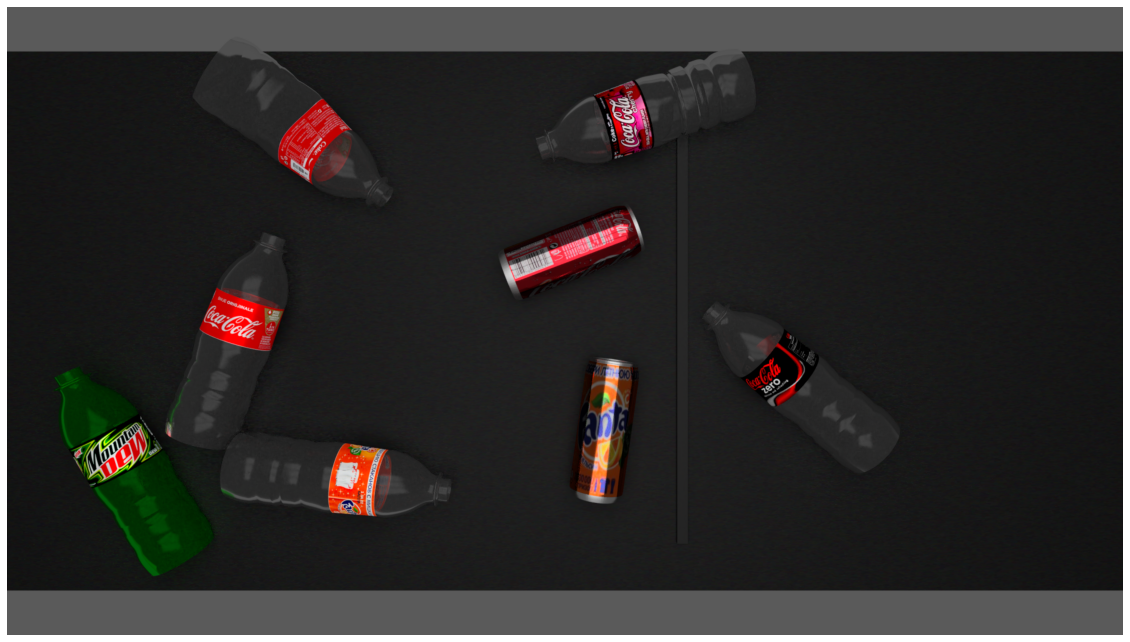

tensor([[ 845.2293,  343.6894, 1094.0100,  503.5420],
        [  80.3972,  626.3301,  355.6682,  977.2568],
        [ 968.5529,  604.5632, 1086.6934,  850.9050],
        [ 914.8134,   73.8836, 1291.2734,  269.3404],
        [1195.4513,  505.8633, 1534.2711,  798.7935],
        [ 362.7859,  732.8396,  761.4949,  873.9833],
        [ 273.1673,  386.5975,  479.9649,  768.8798],
        [ 320.7018,   44.6562,  666.9595,  344.5913]], device='cuda:0')
INFO:	plotting 8 images in a grid of 1x8 @ (20, 20)


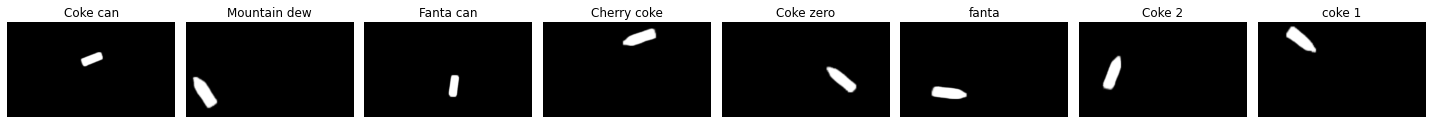

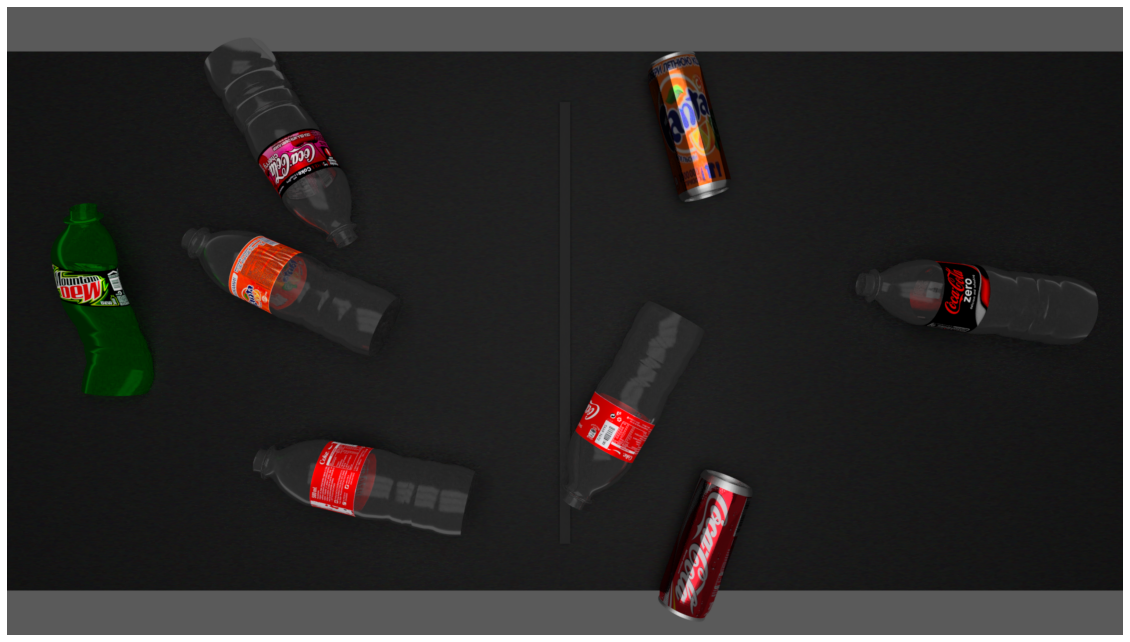

tensor([[1099.5305,   77.7789, 1247.3878,  338.1455],
        [  72.4950,  339.1020,  251.7949,  671.0270],
        [1119.5245,  797.8524, 1282.5166, 1056.2289],
        [ 341.2543,   51.9713,  601.4165,  411.9749],
        [1461.1187,  436.3904, 1877.5271,  579.1478],
        [ 303.0573,  378.6558,  672.0397,  600.5722],
        [ 959.1723,  505.7358, 1200.8412,  856.8705],
        [ 423.1083,  744.8621,  810.1401,  909.9677]], device='cuda:0')
INFO:	plotting 8 images in a grid of 1x8 @ (20, 20)


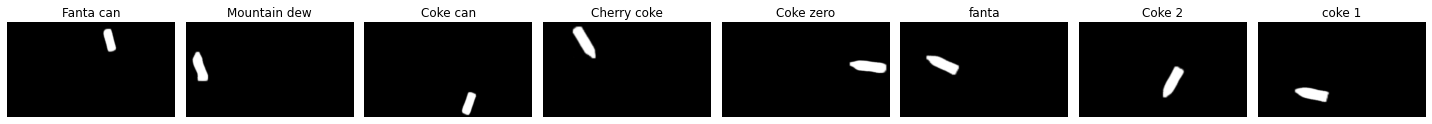

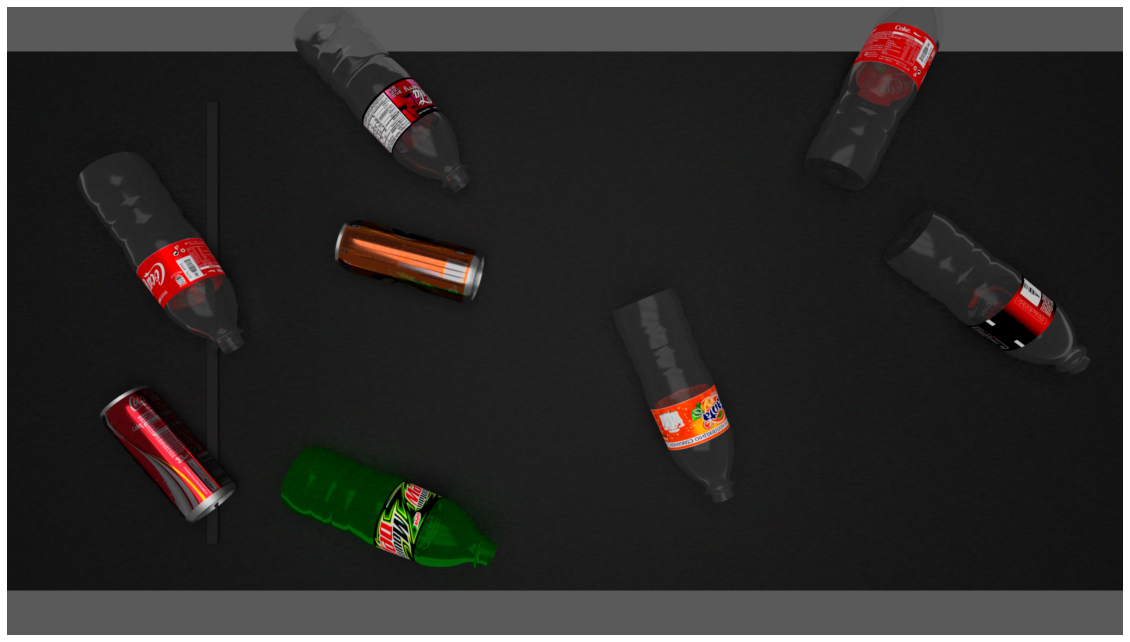

tensor([[ 474.6797,  755.9263,  844.1125,  964.4459],
        [ 567.7265,  364.9113,  825.1876,  509.9884],
        [ 495.4845,    0.0000,  794.7488,  318.8043],
        [ 159.5081,  654.9172,  395.1390,  888.0327],
        [1039.0912,  483.6696, 1251.1790,  852.1747],
        [1509.8418,  347.6162, 1856.0332,  626.3580],
        [ 121.8896,  247.9422,  411.4884,  592.5394],
        [1373.3300,    0.0000, 1603.3059,  314.9362]], device='cuda:0')
INFO:	plotting 8 images in a grid of 1x8 @ (20, 20)


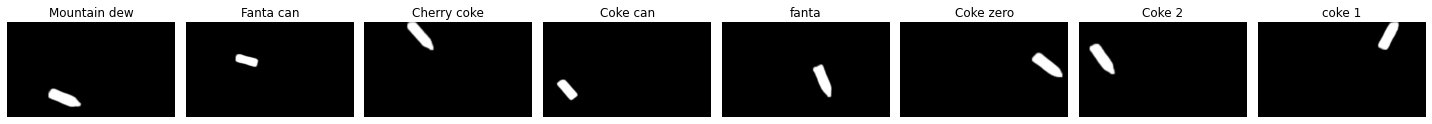

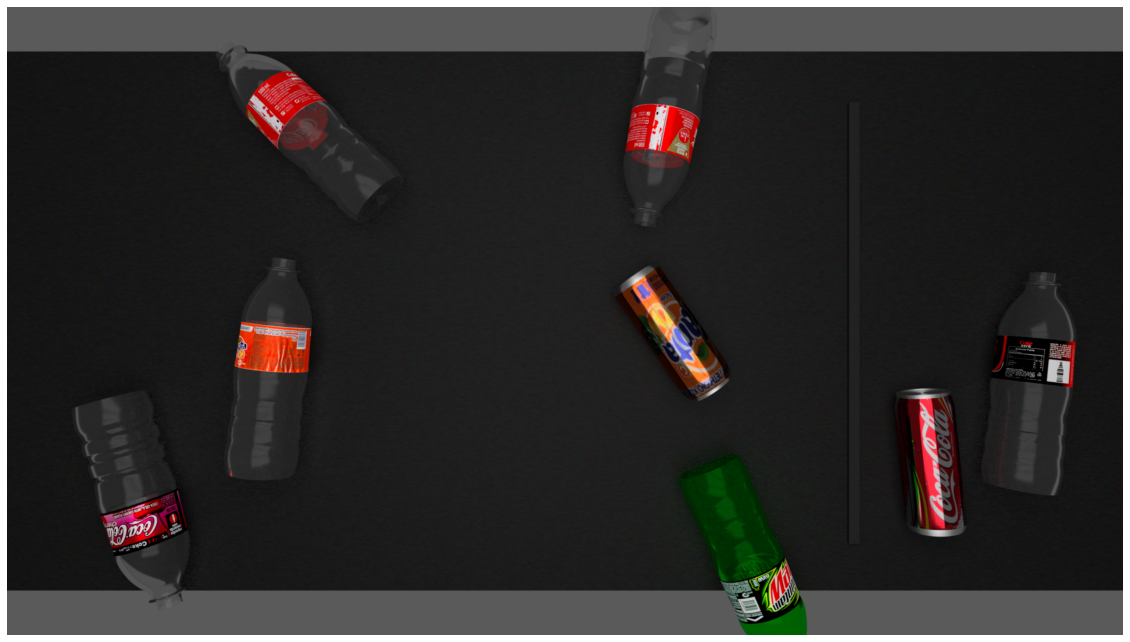

tensor([[1155.1694,  771.6613, 1375.7396, 1080.0000],
        [1041.8947,  442.0173, 1247.7428,  674.8749],
        [ 113.3386,  659.3673,  311.9944, 1031.8605],
        [1528.6437,  658.5563, 1652.2319,  911.0176],
        [1678.4158,  455.5755, 1837.3593,  836.4733],
        [ 373.0344,  427.2679,  527.4005,  815.4036],
        [1059.6001,    0.0000, 1225.6642,  375.2061],
        [ 363.1513,   61.7864,  681.9460,  367.8422]], device='cuda:0')
INFO:	plotting 8 images in a grid of 1x8 @ (20, 20)


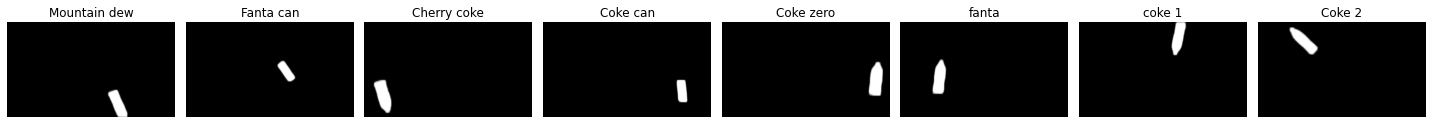

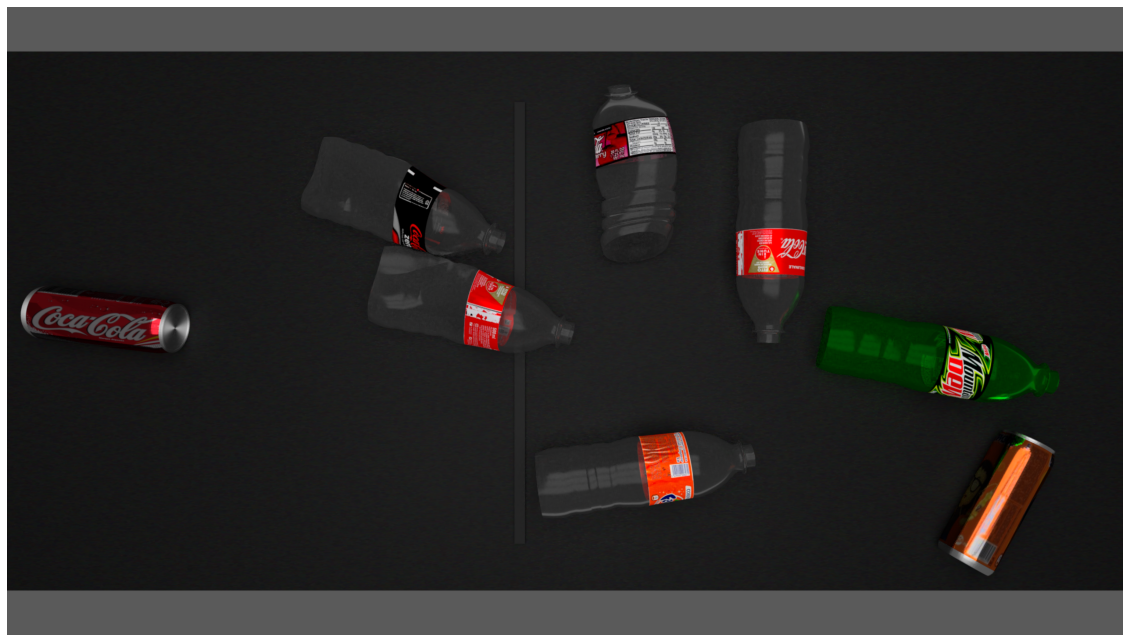

tensor([[1390.0339,  505.8615, 1811.8087,  678.3290],
        [1596.6600,  726.8651, 1803.6162,  977.6695],
        [ 505.0429,  225.4877,  856.5197,  433.0014],
        [  25.4993,  481.8070,  304.3859,  594.4282],
        [1008.3921,  130.1912, 1155.7668,  428.9583],
        [ 910.6521,  731.0399, 1286.3176,  875.1441],
        [1250.2596,  187.5117, 1383.2942,  579.6743],
        [ 616.0278,  412.1036,  967.8217,  593.4127]], device='cuda:0')
INFO:	plotting 8 images in a grid of 1x8 @ (20, 20)


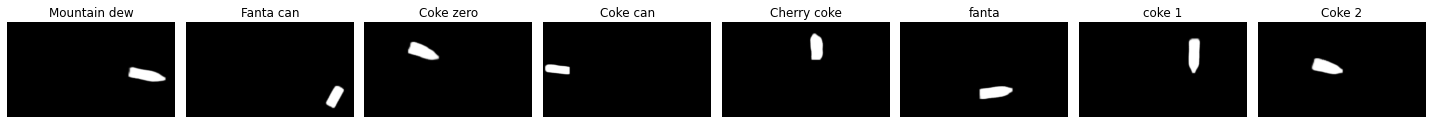

In [98]:
from torchvision.utils import draw_bounding_boxes

for j in range(5):

    l = []
    id = []
    name = []
    for i in range(len(prediction[j][0]["boxes"])):

        if prediction[j][0]['labels'][i] not in id:

          if prediction[j][0]['labels'][i] == 1:
            name.append("coke 1")
          elif prediction[j][0]['labels'][i] == 2:
            name.append("fanta")
          elif prediction[j][0]['labels'][i] == 3:
            name.append("Cherry coke")
          elif prediction[j][0]['labels'][i] == 4:
            name.append("Coke zero")
          elif prediction[j][0]['labels'][i] == 5:
            name.append("Mountain dew")
          elif prediction[j][0]['labels'][i] == 6:
            name.append("Coke 2")
          elif prediction[j][0]['labels'][i] == 7:
            name.append("Fanta can")
          else:
            name.append("Coke can")
          #print(name,i)

          id.append(prediction[j][0]['labels'][i])
          l.append(Image.fromarray(prediction[j][0]['masks'][i, 0].mul(255).byte().cpu().numpy()))

    show(Image.fromarray(img[j].mul(255).permute(1, 2, 0).byte().numpy()))
    print(prediction[j][0]['boxes'][0:8])
    subplots(l,nc=len(id), titles=name,figsize = (20,20))
    

#Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

In [89]:
prediction[0][j]['boxes'][1].cpu().numpy()[0]

80.39724